In [1]:
 query=""" 
SELECT
  Text
FROM
  `emirates-ga-cloud-staging.Vision_Data.Vision_Data_120180804`
GROUP BY
  1
"""
import google.datalab.bigquery as bq
df = bq.Query(query).execute().result().to_dataframe()
#df.head()

/usr/local/envs/py2env/lib/python2.7/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


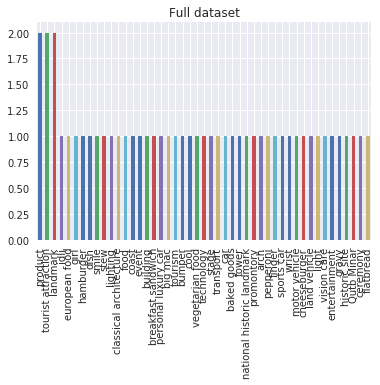

In [2]:
import matplotlib.pyplot as plt
import google.datalab.bigquery as bq
df = bq.Query("SELECT FileName, Text FROM Vision_Data.Vision_Data_120180804 limit 50").execute().result().to_dataframe()
df['Text'].value_counts().plot(kind='bar', title='Full dataset');

In [8]:
!pip install WordCloud

  Using cached https://files.pythonhosted.org/packages/8e/4e/9e01986bb40886bb71b572115cead5f445f7221a285a407d2274be21fc27/wordcloud-1.5.0-cp27-cp27mu-manylinux1_x86_64.whl


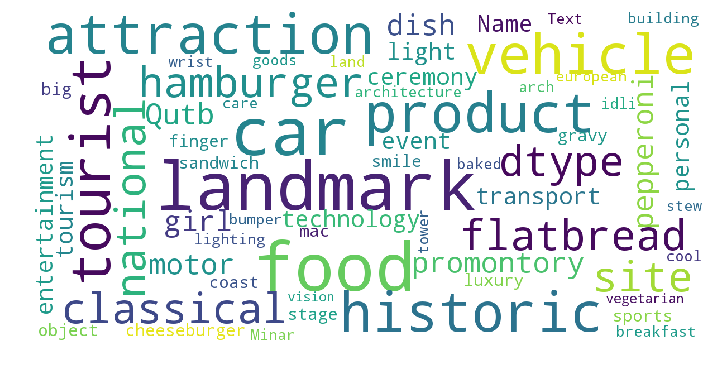

In [9]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
stopwords = set(STOPWORDS)

def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['Text'])

In [2]:
import os
import pandas as pd
import numpy as np
import google.datalab.storage as storage
from io import BytesIO

mybucket = storage.Bucket('cloud_vision_files')
data_csv = mybucket.object('glove.6B.100d.txt')

uri = data_csv.uri
print uri
%gcs read --object $uri --variable data1
embeddings_index = {}
# Category -> words
data = {
  'Events': ['birthday','meeting','wedding','party'],
  'Places': ['tokyo','bejing','washington','mumbai','paris','france'],
  'Food': ['foodstuff','indiancuisine','fastfood','naturalfoo d','idli','dosa','gravy','cake','bread','biryani','apple'],
  'Brand':['samsung','toyata','bmw','mcdonalds','apple']
}
# Words -> category
categories = {word: key for key, words in data.items() for word in words}
#dfText = pd.read_fwf(BytesIO(data1))
for line in BytesIO(data1):
    values = line.split()
    word = values[0]
    embed = np.array(values[1:], dtype=np.float32)
    embeddings_index[word] = embed
print('Loaded %s word vectors.' % len(embeddings_index))

# Embeddings for available words
data_embeddings = {key: value for key, value in embeddings_index.items() if key in categories.keys()}
# Processing the query


gs://cloud_vision_files/glove.6B.100d.txt
Loaded 400000 word vectors.


In [3]:
def process(query):
  query_embed = embeddings_index[query]  
  scores = {}
  for word, embed in data_embeddings.items():
    category = categories[word]
    dist = query_embed.dot(embed)
    dist /= len(data[category])
    scores[category] = scores.get(category, 0) + dist
  return scores


In [ ]:

import math
resultList = []
for index, row in df.iterrows():
  value = row['Text']
  value = value.replace(' ','')
  try:
      #print('Actual Text:', value ,' Result :',process(value))
      result = process(value)
      resultCategory = ''
      rsltFood = math.ceil(result['Food']*100)/100
      rsltBrand = math.ceil(result['Brand']*100)/100
      rsltEvents = math.ceil(result['Events']*100)/100
      rsltPlaces = math.ceil(result['Places']*100)/100
      if (rsltFood > rsltBrand) and (rsltFood > rsltEvents) and (rsltFood > rsltPlaces):
            resultCategory = 'Food'
      elif(rsltBrand > rsltFood) and (rsltBrand > rsltEvents) and (rsltBrand > rsltPlaces):
            resultCategory = 'Brand'
      elif(rsltEvents > rsltFood) and (rsltEvents > rsltBrand) and (rsltEvents > rsltPlaces):
            resultCategory = 'Events'
      elif(rsltPlaces > rsltFood) and (rsltPlaces > rsltBrand) and (rsltPlaces > rsltEvents):
            resultCategory = 'Places'
      
      newData = {'Text': [value,resultCategory]}
      my_2darray = np.array([value,resultCategory])
      resultList.append(my_2darray)
      #newdf = pd.DataFrame(data=newData, columns=['Text','result'])      
    #print('Actual Text:', value ,' Result Category :',resultCategory)      
  except:
      print('error')
        


In [ ]:
import datalab.bigquery as bq
import pandas as pd
import numpy as np
# Dataframe to write
simple_dataframe = pd.DataFrame(resultList, columns=['Text','Result'])
print(simple_dataframe.head())
bigquery_dataset_name = 'Vision_Data'
bigquery_table_name = 'Process_Data'

# Define BigQuery dataset and table
dataset = bq.Dataset(bigquery_dataset_name)
table = bq.Table(bigquery_dataset_name + '.' + bigquery_table_name)

# Create BigQuery dataset
if not dataset.exists():
    dataset.create()

# Create or overwrite the existing table if it exists
table_schema = bq.Schema.from_dataframe(simple_dataframe)
table.create(schema = table_schema, overwrite = True)

# Write the DataFrame to a BigQuery table
table.insert_data(simple_dataframe)

In [18]:
query1="""
SELECT
  Text
FROM
  `emirates-ga-cloud-staging.Vision_Data.Process_Data`
GROUP BY
  1
"""
import google.datalab.bigquery as bq
dfResult = bq.Query(query1).execute().result().to_dataframe()
#dfResult.head()

In [ ]:
show_wordcloud(dfResult['Text'])

In [15]:
query1="""
SELECT
  Result as Category, count(Text) as LablesCount 
FROM
  `emirates-ga-cloud-staging.Vision_Data.Process_Data` WHERE Result != ''
  GROUP BY
  1
"""
import google.datalab.bigquery as bq
dfFinalResult = bq.Query(query1).execute().result().to_dataframe() 

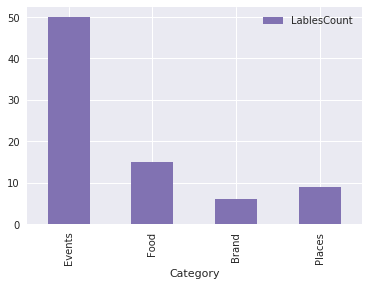

In [16]:
dfFinalResult.plot(x="Category", y=["LablesCount"], kind="bar",color="C3")